# Chapter 2 - Bias-Variance Tradeoff

In this tutorial, we will look at how the bias-variance tradeoff shows through four examples

Recall that,
- Bias is the tendancy of an estimator to pick a model for the data that is not structurally correct. A biased estimator is one that makes incorrect assumptions on the model level about the dataset.
- Variance is error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (overfitting)

Below figure shows different cases of bias and variance that a model can show (source: http://scott.fortmann-roe.com/docs/BiasVariance.html)

![Bias-Variance](https://gitlab.com/machine-learning-course1/ml-practice-lg-2024-spring/-/raw/main/Images/Low-High-Variances-Biases.png)

In [1]:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pylab as pl
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
%matplotlib inline

BASE_DIR = 'https://gitlab.com/machine-learning-course1/ml-practice-lg-2024-spring/-/raw/master/Notebooks'

# 1. Polynomial Regression

## 1.1. Basic Example

### 1.1.1. Data Generation

First we will write a function to generate a random sample. The data generation model is the following:

$$Y = f(x) + \epsilon$$

with $f(x) = 2sin(1.5x)$ and $\epsilon\sim\mathcal{N}(0,1)$

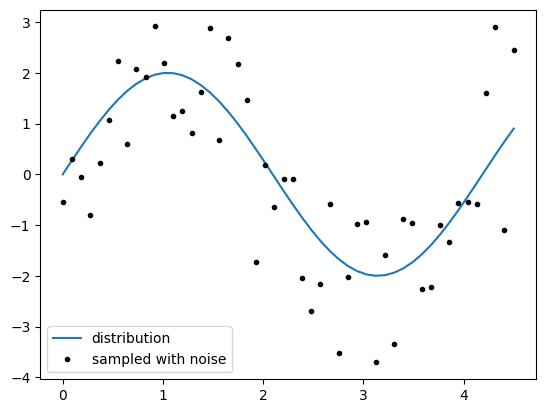

In [2]:
def f(num_samples):
    '''
    Returns a sample with 'num_samples' instances without noise.
    '''
    x = np.linspace(0, 4.5, num_samples)
    y = 2 * np.sin(x * 1.5)
    return x, y

def sample(num_samples):
    '''
    Returns a sample with 'num_samples' instances.
    '''
    x = np.linspace(0, 4.5, num_samples)
    y = 2 * np.sin(x * 1.5) + pl.randn(x.size)
    return x, y
    
x_ideal, y_ideal = f(50)
x, y = sample(50)

plt.figure()
plt.plot(x_ideal, y_ideal, label='distribution')
plt.plot(x, y, 'k.', label='sampled with noise')
plt.legend()
plt.show()

### 1.1.2. Model Fitting

We will use least square regression (LSR) to fit a polynomial to the data. Actually, we will use multivariate linear regression, over a dataset built in the following way:

For each sample $x_{i}$ we build a vector $(1 , x_{i} , x_{i}^{2} , \dots , x_{i}^{n})$  and we use LSR to fit a function $g:\mathbb{R}^{n+1}\rightarrow\mathbb{R}$ to the training data.

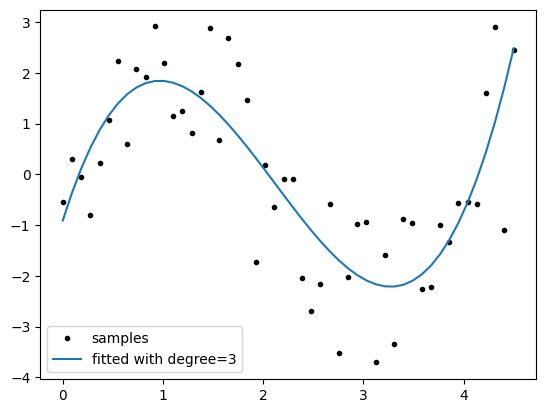

In [3]:
def fit_polynomial(x, y, degree):
    '''
    Fits a polynomial to the input sample.
    x, y: input sample
    degree: polynomial degree
    '''
    model = LinearRegression()
    model.fit(np.vander(x, degree + 1), y) # https://numpy.org/doc/stable/reference/generated/numpy.vander.html
    return model

def apply_polynomial(model, x):
    '''
    Evaluates a linear regression model in an input sample
    model: linear regression model
    x: input sample
    '''
    degree = model.coef_.size - 1
    y = model.predict(np.vander(x, degree + 1)) # https://numpy.org/doc/stable/reference/generated/numpy.vander.html
    return y

n_degrees = 3
model = fit_polynomial(x, y, n_degrees)
y_pred = apply_polynomial(model, x)

plt.figure()
plt.plot(x, y, 'k.', label='samples')
plt.plot(x, y_pred, label='fitted with degree={}'.format(n_degrees))
plt.legend()
plt.show()

### 1.1.3. Model Averaging

The following code generates a set of samples of the same size and fits a poynomial to each sample. Then the average model is calculated. All the models, including the average model, are plotted.

Try the model fitting for different degree of polynomial by changing $degree$, and see how much each fitted models vary

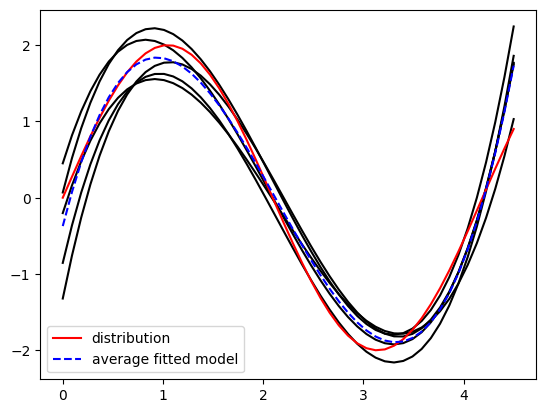

In [4]:
degree = 3
n_samples = 50
n_models = 5

y_avg = np.zeros(n_samples)
for i in range(n_models):
    x, y = sample(n_samples)
    model = fit_polynomial(x, y, degree)
    y_pred = apply_polynomial(model, x)
    y_avg = y_avg + y_pred
    plt.plot(x, y_pred, 'k-')
y_avg = y_avg / n_models

#plt.plot(x, y, 'k.', label = 'samples')
plt.plot(x_ideal, y_ideal, 'r', label='distribution')
plt.plot(x, y_avg, 'b--', label = 'average fitted model')
plt.legend()
plt.show()

### 1.1.4. Calculate and visualize the Bias-Variance Tradeoff

Same as previous example, we generate several samples and fit a polynomial to each one. We calculate bias an variance among models for different polynomial degrees. Bias, variance and error are plotted against different degree values.

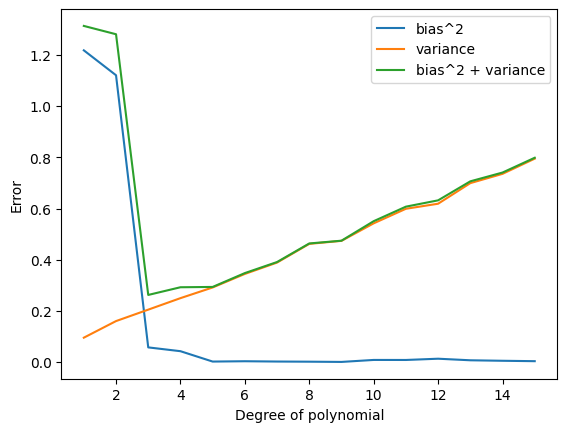

In [5]:
n_samples = 20
x_ideal, y_ideal = f(n_samples)

n_models = 100
max_degree = 15

bias_vals = []
var_vals =[]
sum_of_bias_var_vals = []

for degree in range(1, max_degree+1):
    y_avg = np.zeros(n_samples)
    y_preds = []
    train_mse = 0
    for i in range(n_models):
        x, y = sample(n_samples)
        model = fit_polynomial(x, y, degree)
        y_pred = apply_polynomial(model, x)
        y_avg = y_avg + y_pred
        y_preds.append(y_pred)
    y_avg = y_avg / n_models
    
    bias = y_avg - y_ideal
    variance = 0
    for y_pred in y_preds:
        variance += np.square(y_avg - y_pred)
    variance /= n_models
    
    bias_vals.append(np.mean(np.square(bias)))
    var_vals.append(np.mean(variance))
    sum_of_bias_var_vals.append(np.mean(np.square(bias) + variance))

plt.plot(range(1, max_degree+1), bias_vals, label='bias^2')
plt.plot(range(1, max_degree+1), var_vals, label='variance')
plt.plot(range(1, max_degree+1), sum_of_bias_var_vals, label='bias^2 + variance')
plt.legend()
plt.xlabel('Degree of polynomial')
plt.ylabel('Error')
plt.show()

### 1.1.5. Exercise: Repeat the Above Process

Repeat the above process for the following settings
1. Generate the sample data (20 samples) from the model $ f(x) = 5x^5$ and $Y = f(x) + \epsilon$ ($\epsilon\sim\mathcal{N}(0,20^2)$)
2. Fit the sampled data with a polynomial with degree 3 and plot the fitted values 
3. Repeat the sampling and fitting process for degrees 1,2, ... , 10 (100 times per each degree), and plot the bias and the variance values of the fitted models

In [ ]:
 def f(num_samples):
    '''
    Returns a sample with 'num_samples' instances without noise.
    '''
    x = np.linspace(-2, 2, num_samples)
    y = 
    return x, y

def sample(num_samples):
    '''
    Returns a sample with 'num_samples' instances without noise.
    '''
    x = np.linspace(-2, 2, num_samples)
    y = 
    return x, y

# sample the data and plot
n_samples = 20
x_ideal, y_ideal = f(n_samples)
x, y = sample(n_samples)

plt.figure()
plt.plot(x_ideal, y_ideal, label='distribution')
plt.plot(x, y, 'k.', label='sampled with noise')
plt.legend()
plt.show()

# fit the sampled data with a polynomial of degree 3 and plot




# Repeat the sampling and fitting process for degrees 1,2, ... , 10 (100 times per each degree), 
# and plot the bias and the variance values of the fitted models















## 1.2. Exercise: Position of an Object Thrown Upwards to the Air

As an excercise, we will try fitting a polynomial to model the height of the object thrown up in the air over time.

This example was referenced from https://medium.com/towards-artificial-intelligence/bias-variance-tradeoff-illustration-using-pylab-202943bf4c78

### 1.2.1. Visualize Data

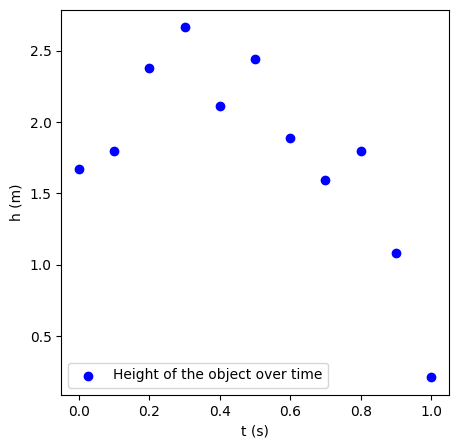

In [7]:
t = np.linspace(0,1,11)
h = np.array([1.67203, 1.79792, 2.37791,2.66408,2.11245, 2.43969,1.88843, 1.59447,1.79634,1.07810,0.21066])

plt.figure(figsize=(5,5))
plt.scatter(t,h, c='b', label='Height of the object over time')
plt.legend()
plt.xlabel('t (s)')
plt.ylabel('h (m)')
plt.show()

### 1.2.2. Model Fitting

Fit the above data with polynomials with different degrees, and calculate the Mean Square Error (MSE) of the fitted values

# 2. K Nearest Neighbor Classification

https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/

## 2.1. Human Activity Recognition

We are first going to use a simple Human Activity Recognition (HAR) dataset to implement KNN from scratch.  

### 2.1.1. Load Dataset

The dataset contains the average (mean) and standard deviation of the accelerometer values recorded while the participant was performing 3 different actions (standing, walking, and running).

In [9]:
dataset = pd.read_csv(f'{BASE_DIR}/Data/HAR-simple.csv', names=['mean', 'std', 'class'])
dataset.head()

,mean,std,class
0,21.102907,5.765471,running
1,21.021069,6.140544,running
2,21.183245,5.867254,running
3,21.053389,5.808249,running
4,20.079922,6.108489,running


### 2.1.2. Visualize

Plot the data samples to see how the (mean, std) values differ for different activities

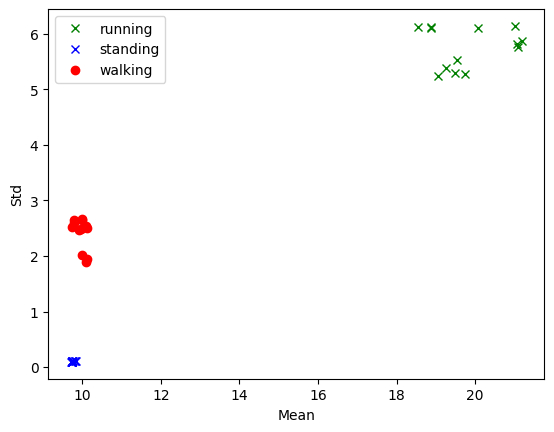

In [10]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, 2].values

plt.figure()
for x_sample, y_sample in zip(X, y):
    if y_sample == 'walking':
        plt.plot(x_sample[0], x_sample[1], 'ro', label=y_sample)
    elif y_sample == 'running':
        plt.plot(x_sample[0], x_sample[1], 'gx', label=y_sample)
    elif y_sample == 'standing':
        plt.plot(x_sample[0], x_sample[1], 'bx', label=y_sample)
    else:
        raise ValueError('Wrong label: {}'.format(y_sample))
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

### 2.1.3. Find K Nearest Neighbors

Use the first 30 samples (10 samples per each activity) as training set, and the last 10 samples as testset. Randomly pick a test sample, find K nearest neighbors, and predict the label. 

[7 8 4 5 6]
['running' 'running' 'running' 'running' 'running']
Test sample idx:  3 , Ground truth:  running , predicted:  running


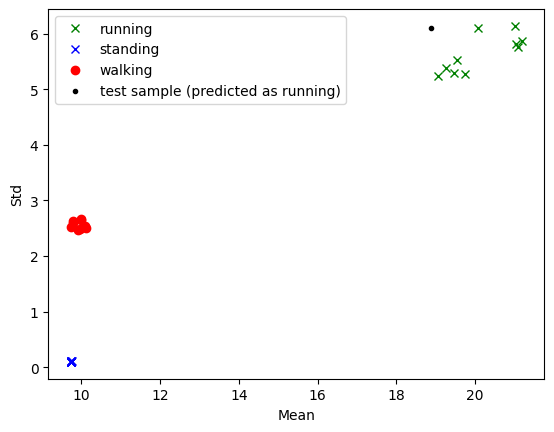

In [11]:
# Split the dataset into train and testset
X_train = X[0:30]
X_test = X[30:]
y_train = y[0:30]
y_test = y[30:]

# Randomly pick a test sample
idx = np.random.randint(10)
x_sample = X_test[idx]
y_sample = y_test[idx]

# Calculate distances with each training samples
distance = [np.sum(np.abs(x - x_sample)) for x in X_train]
    
# Find K nearest neighbors
K = 5
neighbors_idx = np.argsort(distance)[:K]
print(neighbors_idx)
y_neighbors = y_train[neighbors_idx]
print(y_neighbors)

# Choose most common one
y_pred = Counter(y_neighbors).most_common()[0][0]

# Compare with ground truth
print('Test sample idx: ', idx, ', Ground truth: ', y_test[idx], ', predicted: ', y_pred)

# Visualize
plt.figure()
for i in range(X_train.shape[0]):
    if y[i]=='walking':
        plt.plot(X_train[i][0], X_train[i][1], 'ro', label = 'walking')
    elif y[i]=='running':
        plt.plot(X_train[i][0], X_train[i][1], 'gx', label = 'running')
    else:
        plt.plot(X_train[i][0], X_train[i][1], 'bx', label = 'standing')
        
plt.plot(X_test[idx][0], X_test[idx][1], 'k.', label = 'test sample (predicted as {})'.format(y_pred))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

## 2.2. IRIS Classification


Next, we are going to use the famous iris data set for our KNN example. The dataset consists of four attributes: sepal-width, sepal-length, petal-width and petal-length. These are the attributes of specific types of iris plant. The task is to predict the class to which these plants belong. There are three classes in the dataset: Iris-setosa, Iris-versicolor and Iris-virginica. Further details of the dataset are available here.

![Iris dataset](https://gitlab.com/machine-learning-course1/ml-practice-lg-2024-spring/-/raw/main/Images/iris.jpg)

### 2.2.1. Load Dataset

In [12]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

# Assign colum names to the dataset
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'Class']

# Read dataset to pandas dataframe
dataset = pd.read_csv(url, names=names)
dataset.head()

,sepal-length,sepal-width,petal-length,petal-width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### 2.2.2. Split the data into attributes and labels

The next step is to split our dataset into its attributes and labels. To do so, use the following code:

In [13]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, 4].values

### 2.2.3. Split the data into train and test datasets

To avoid over-fitting, we will divide our dataset into training and test splits, which gives us a better idea as to how our algorithm performed during the testing phase. This way our algorithm is tested on un-seen data, as it would be in a production application.

To create training and test splits, execute the following script:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

### 2.2.4. Feature Scaling

Before making any actual predictions, it is always a good practice to scale the features so that all of them can be uniformly evaluated. Wikipedia explains the reasoning pretty well:

Since the range of values of raw data varies widely, in some machine learning algorithms, objective functions will not work properly without normalization. For example, the majority of classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a broad range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

The gradient descent algorithm (which is used in neural network training and other machine learning algorithms) also converges faster with normalized features.

The following script performs feature scaling:

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)

print('Before scaling, X_train range {:.4f} - {:.4f}'.format(np.min(X_train), np.max(X_train)))
X_train = scaler.transform(X_train)
print('After scaling, X_train range {:.4f} - {:.4f}'.format(np.min(X_train), np.max(X_train)))
print('Before scaling, X_test range {:.4f} - {:.4f}'.format(np.min(X_test), np.max(X_test)))
X_test = scaler.transform(X_test)
print('After scaling, X_test range {:.4f} - {:.4f}'.format(np.min(X_test), np.max(X_test)))

Before scaling, X_train range 0.1000 - 7.9000
After scaling, X_train range -2.3626 - 3.0634
Before scaling, X_test range 0.1000 - 7.2000
After scaling, X_test range -1.4769 - 1.7069


### 2.2.5. Training
It is extremely straight forward to train the KNN algorithm and make predictions with it, especially when using Scikit-Learn.

The first step is to import the KNeighborsClassifier class from the sklearn.neighbors library. In the second line, this class is initialized with one parameter, i.e. n_neigbours. This is basically the value for the K. There is no ideal value for K and it is selected after testing and evaluation, however to start out, 5 seems to be the most commonly used value for KNN algorithm.

In [16]:
cls = KNeighborsClassifier(n_neighbors=5)
cls.fit(X_train, y_train)

KNeighborsClassifier()

### 2.2.6. Prediction
The final step is to make predictions on our test data. To do so, execute the following script:

In [17]:
y_pred = cls.predict(X_test)

### 2.2.7. Evaluation

For evaluating an algorithm, confusion matrix, precision, recall and f1 score are the most commonly used metrics. The confusion_matrix and classification_report methods of the sklearn.metrics can be used to calculate these metrics. Take a look at the following script:

In [18]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.91      1.00      0.95        10
 Iris-virginica       1.00      0.90      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



### 2.2.8. Comparing the Error Rate with Different K Values

In the training and prediction section we said that there is no way to know beforehand which value of K that yields the best results in the first go. We randomly chose 5 as the K value and it just happen to result in 100% accuracy.

One way to help you find the best value of K is to plot the graph of K value and the corresponding error rate for the dataset.

In this section, we will plot the mean error for the predicted values of test set for all the K values between 1 and 40.

To do so, let's first calculate the mean of error for all the predicted values where K ranges from 1 and 40. Execute the following script:

In [19]:
error = []

# Calculate the error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

### 2.2.9. Plot Error Rates

The final step is to plot the error values against K values. Execute the following script to create the plot:

From the output we can see that the mean error is zero when the value of the K is between 5 and 18. I would advise you to play around with the value of K to see how it impacts the accuracy of the predictions.

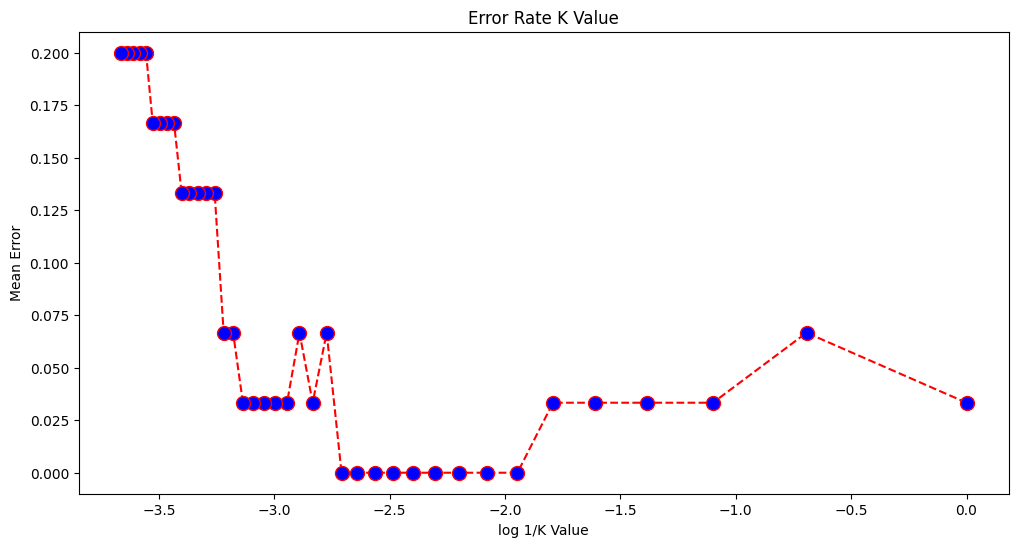

In [20]:
plt.figure(figsize=(12, 6))
plt.plot([np.log(1/k) for k in range(1, 40)], error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('log 1/K Value')
plt.ylabel('Mean Error')
plt.show()

# 3. Proof of the Bias Variance Tradeoff

Recall that,

<img src="https://gitlab.com/machine-learning-course1/ml-practice-lg-2024-spring/-/raw/main/Images/preliminary.PNG" width="400">

with this, we can prove the bias-variance tradeoff as follows.

![proof](https://gitlab.com/machine-learning-course1/ml-practice-lg-2024-spring/-/raw/main/Images/bias-variance-tradeoff-proof.PNG)